In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
hm450_hg19=pd.read_csv('../data/hm450.hg19.manifest.bed', sep='\t', header=None)
hm450_hg19

,0,1,2,3,4
0,chr1,15864,15866,-,cg13869341
1,chr1,18826,18828,-,cg14008030
2,chr1,29406,29408,-,cg12045430
3,chr1,29424,29426,-,cg20826792
4,chr1,29434,29436,-,cg00381604
...,...,...,...,...,...
485572,chrM,6761,6763,-,cg05001044
485573,chrM,6797,6799,+,cg03344490
485574,chrM,7196,7198,-,cg18024856
485575,chrM,9054,9056,+,cg03348902


In [3]:
marker_to_chr_pos_tuple = dict(zip(hm450_hg19[4], zip(hm450_hg19[0], hm450_hg19[2] - 1)))
horvath_coef = pd.read_csv("../data/gb-2013-14-10-r115-S3.csv")
markers = horvath_coef["CpGmarker"]
coefs = horvath_coef["CoefficientTraining"]
horvath_chrs = markers.apply(marker_to_chr_pos_tuple.get)

In [4]:
data = pd.read_csv("../data/sorted_filtered_cytosines_freq.tsv", sep='\t')

In [5]:
chromosome, position = np.transpose([name.split(".") for name in data.values[:, 0]])
position = position.astype(int)

def compare_chr(chr1, p1, chr2, p2):
    return chr1 < chr2 or (chr1 == chr2 and p1 < p2)

def binary_search(c, p):
    left = 0
    right = len(chromosome)
    while right - left > 1:
        mid = (right + left) // 2
        if compare_chr(c, p, chromosome[mid], position[mid]):
            right = mid
        else:
            left = mid
    return left

In [6]:
horvath_ind = horvath_chrs.apply(lambda tup: binary_search(*tup))
data.values[horvath_ind][:, 1:]

array([[90.909, 100.0, 90.0, ..., 95.349, 100.0, 90.323],
       [100.0, 98.571, 100.0, ..., 91.667, 100.0, 100.0],
       [0.0, 0.0, 0.0, ..., 0.87, 1.923, 1.429],
       ...,
       [87.5, 100.0, 37.5, ..., 71.429, 50.0, 100.0],
       [10.526, 0.0, 6.349, ..., 1.389, 3.947, 9.677],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.758]], dtype=object)

In [7]:
np.isnan(data.values[horvath_ind][:, 1:].astype(np.float64)).sum()

166

In [8]:
import methyLImp
imputed_methylimp = methyLImp.methyLImp(data.values[horvath_ind][:, 1:].transpose().astype(np.float64) / 100.0001)
imputed_methylimp

array([[0.90908909, 0.999999  , 0.        , ..., 0.87499913, 0.10525989,
        0.        ],
       [0.999999  , 0.98570901, 0.        , ..., 0.999999  , 0.        ,
        0.        ],
       [0.8999991 , 0.999999  , 0.        , ..., 0.37499963, 0.06348994,
        0.        ],
       ...,
       [0.95348905, 0.91666908, 0.00869999, ..., 0.71428929, 0.01388999,
        0.        ],
       [0.999999  , 0.999999  , 0.01922998, ..., 0.4999995 , 0.03946996,
        0.        ],
       [0.9032291 , 0.999999  , 0.01428999, ..., 0.999999  , 0.0967699 ,
        0.00757999]])

In [9]:
data.values[horvath_ind][:, 1:].transpose().astype(np.float64) / 100

array([[0.90909, 1.     , 0.     , ..., 0.875  , 0.10526, 0.     ],
       [1.     , 0.98571, 0.     , ..., 1.     , 0.     , 0.     ],
       [0.9    , 1.     , 0.     , ..., 0.375  , 0.06349, 0.     ],
       ...,
       [0.95349, 0.91667, 0.0087 , ..., 0.71429, 0.01389, 0.     ],
       [1.     , 1.     , 0.01923, ..., 0.5    , 0.03947, 0.     ],
       [0.90323, 1.     , 0.01429, ..., 1.     , 0.09677, 0.00758]])

In [10]:
out = (imputed_methylimp.astype(np.float64)).dot(coefs.astype(np.float64)) + 0.695507258

In [11]:
def F_inv(x):
    if x < 0:
        return 21 * np.exp(x) - 1
    else:
        return 21 * x + 20

In [12]:
predicted_age = np.vectorize(F_inv)(out)

In [13]:
real_age = pd.read_csv("../data/RRBS.phase1_yo_datasets.Monocyte.tsv", sep='\t')
real_age["Donor Age"] - predicted_age

0      1.619626
1      2.768839
2    -12.680183
3    -11.163624
4    -13.429206
5     -5.198064
6     -0.148214
7      7.258987
8    -11.289490
9     -0.258009
10    10.947322
11   -10.111699
12    -4.150764
13    -7.140494
14    -8.799883
15    -1.419917
16     0.667408
17    -8.993310
18    -0.712696
19    -9.796158
20    44.069767
21    42.873284
22    42.583954
23    38.453825
24    43.888469
25    42.526959
26    27.345440
27    34.999827
28    48.596514
29    40.529761
30    42.736526
31    44.967760
32    52.485502
33    36.286471
34    45.380000
35    25.660521
36    47.713886
37    51.932871
38    41.541859
39    50.753517
Name: Donor Age, dtype: float64

Text(0, 0.5, 'predicted')

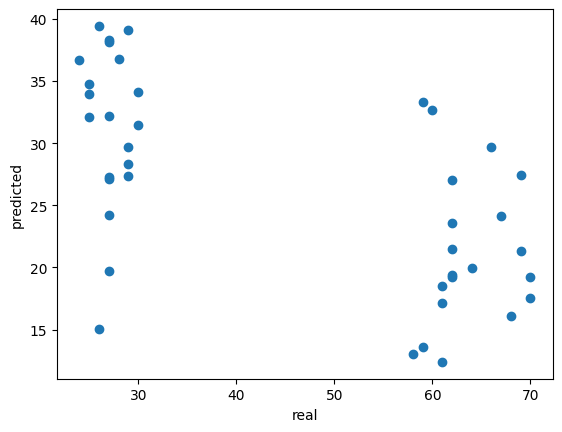

In [16]:
plt.scatter(real_age["Donor Age"].astype(np.float64), predicted_age.astype(np.float64))
plt.xlabel('real')
plt.ylabel('predicted')

Text(0.5, 0, 'Error')

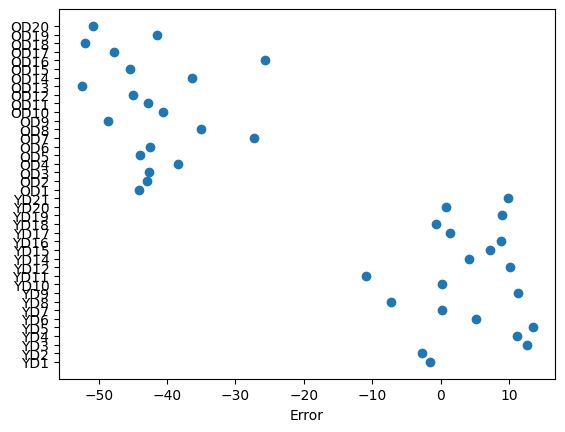

In [17]:
plt.scatter(predicted_age.astype(np.float64) - real_age["Donor Age"].astype(np.float64), real_age["Donor ID"])
plt.xlabel("Error")